# Transformer

- architecture: encoder-decoder. CNN + attention

**Pros of Transformers:**

- *Parallelization:* Unlike RNNs and LSTMs, Transformers can process input tokens in parallel, enabling faster training and inference.

- *Long-range dependencies:* effectively through the self-attention mechanism.

- *Scalability:* can scale to large models and massive amounts of data, as seen in GPT-3 and BERT.

- *Transfer learning:* Pre-trained Transformer models can be fine-tuned for a variety of tasks, allowing for better performance with less data and training time.

**Cons of Transformers:**

- *Memory and computational requirements:* Transformers, especially large models, require significant memory and computational resources for training and inference.

- *Model complexity:* a large number of parameters, making them prone to overfitting, especially on small datasets.

- *Lack of interpretability:* self-attention mechanism can make it difficult to understand and explain their predictions.

- *Longer sequences:* may struggle with very long sequences due to quadratic memory complexity in self-attention.


## Architecture

Encoder-Decoder

- the encoder maps an input sequence of symbol representations $(x_1, ..., x_m)$ to a sequence of continuous representations $z = (z_1, ..., z_m)$. 

- Given $z$, the decoder then generates an output sequence $(y1, ..., y_m)$ of symbols one element at a time.

- encoder is a stack of $N=6$ identical layers, each layer contains 2 sub-layers: 
    
    - a multi-head self-attention mechanism: tokens look at each other 
    
    - a Position-wise FC Feed-Forward network: after taking info from other tokens, take a moment to process the info

- decoder is also a stack of $N=6$ identical layers, each layer has 3 sub-layers:

    - a masked multi-head self-attention mechanism: tokens look at **previous** tokens
    
    - a multi-head decoder-encoder attention mechanism: target token looks at source tokens 
    
    - a Position-wise FC Feed-Forward network: after taking info from other tokens, take a moment to process the info

- each sub-layer has residual connections followed by layer normalization

- Final Linear and Softmax Layer: map decoder output to logit to predicted next-token probabilities.

Positional encoding: added to input/output embeddings to capture positional information of tokens in sequence

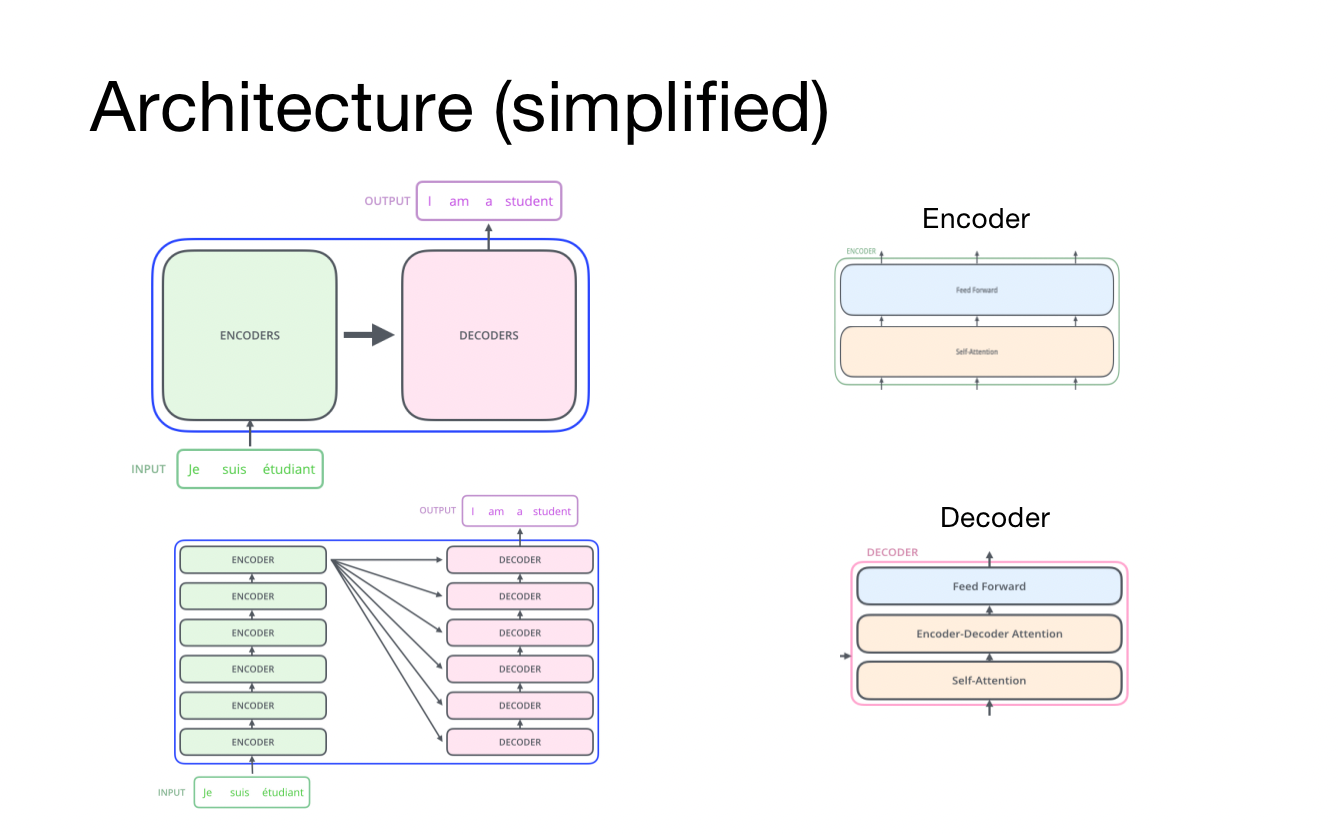

## Attention Mechanism

**An attention function** can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. 

The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

- attention: look up previous info

- query: the thing we want to look up

- keys: the thing that could be looked up

- values: the result of lookup

- scores: how well does query match key?

most commonly used attention function is additive, dot product (used in Transformer), bilinear and MLP

$$
\text{Attention}(Q, K, V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Different types of attention mechanism helps model better capture long-term dependency (context) in sequential data

- **encoder-decoder attention**: 

  help decoder for each time step pay attention to/align target tokens with the most relevent source token 



- **Self-Attention**:

  - encoder or decoder pay attention to its own input
  
  - consider relationships between all tokens in the input sequence/embeddings, not just adjacent ones.

  - Reduces need for recurrent or convolutional layers, allowing for faster and more parallelizable computation.


- **Multi-Head Attention**:

  - capture different features of the input. 

  - Each attention head learns different query, key, and value weight matrices, like multiple conv filters


- **Masked Attention**:

  - Prevents the model from attending to future tokens during training, enforcing the autoregressive property.

  - Ensures that the model generates output tokens based only on the previously generated tokens and the input context.
  
  - Particularly important for tasks like language modeling and sequence generation, where future information should not be available.

### algorithm

Assume we have $H$ attention heads, For each head $h$:

1. input: 

     - self-attention: encoder or decoder embeddings $X$ from last year

     - encoder-decoder attention: both encoder embeddings $X_{enc}$ of encoder final output and decoder embeddings $X_{dec}$ from the last layer


2. **Compute Query (Q), Key (K), and Value (V) matrices** by linear function: 

     - **self-attention**: query, key, value matrices are all computed from input embeddings $X$

          $$
          Q_{h} = X W^{Q_h}, K_{h} = X W^{K_h}, V_{h} = X W^{V_h}
          $$

          query, key, value vector for i th token:  $\mathbf{q}_{i,h} = x_i W^{Q_h}, \mathbf{k}_{i,h} = x_i W^{K_h}, \mathbf{v}_{i,h} = x_i W^{V_h}$


     - **encoder-decoder attention**: queries come from previous decoder layer while memory keys and values come from output of encoder

          $$
          Q_{h} = X_{dec} W^{Q_h}, K_{h} = X_{enc} W^{K_h}, V_{h} = X_{enc} W^{V_h} V_{h}
          $$

          query, key, value vector for i-th token of decoder time step $t$:  $\mathbf{q}^t_{i,h} = x_{t,dec} W^{Q_h}, \mathbf{k}_{i,h} = x_{i,enc} W^{K_h}, \mathbf{v}_{i,h} = x_{i,enc} W^{V_h}$


3. **Compute attention score matrix** $\Alpha_h$: scaled dot product between query matrix and key matrix by square root of dimension of key vectors $d_k$

     $$
     \Alpha_h = \frac{Q_h K_h^T}{\sqrt{d_k}}
     $$
     
     self-attention: attention score between the i-th query and key pair is $\alpha_{i,h} = \frac{\mathbf{q}_{i,h} \cdot \mathbf{k}_{i, h}}{\sqrt{d_k}}$

     encoder-decoder attention: attention score between the t-th query and i-th key pair is $\alpha^t_{i,h} = \frac{\mathbf{q}^t_{i,h} \cdot \mathbf{k}_{i, h}}{\sqrt{d_k}}$


4. **Apply softmax**: Normalize attention scores using softmax function
     
     $$
     A_h = \text{softmax}(\Alpha_h)
     $$
     
     self-attention: normalized attention score between the i-th query and key pair is $a_{i,h} = \text{softmax}(\alpha_{i,h}) = \frac{\exp(\alpha_{i,h})}{\sum_{i=1}^m \exp(\alpha_{i,h})}$

     encoder-decoder attention: normalized attention score between the t-th query and i-th key pair is $a^t_{i,h} = \text{softmax}(\alpha^t_{i,h}) = \frac{\exp(\alpha^t_{i,h})}{\sum_{i=1}^m \exp(\alpha^t_{i,h})}$


5. **Compute context matrix** $C_h$: value matrix weighted by normalized attention scores matrix. 
     
     $$
     C_h = A_h V_h
     $$

     for self-attention, shape $(m, d_v)$: context vector for ith token is $\mathbf{c}_{i, h} = \sum_{i=1}^m a_{i, h} \mathbf{v}_{i,h}$

     for encoder-decoder attention, shape $(n, d_v)$: context vector for ith token is $\mathbf{c}^t_{i, h} = \sum_{i=1}^m a^t_{i, h} \mathbf{v}_{i,h}$


After computing context matrices for all heads:

6. Compute concatenated context matrix $C$: 

   $$
   C = \text{Concat}(C_1, C_2, \dots, C_H)
   $$

7. Output final context matrix $Z$: by projecting the concatenated context matrix to a lower-dimensional space. $Z$ which will serve as input for the next layer. 

   $$Z = C W^O$$


**Notation**

Hyperparameter

- $m$ is source sequence length, the number of tokens in source sequence.

- $n$ is target sequence length, the number of tokens in target sequence

- $H$: number of attention heads

- $d_{\text{model}}$: dimension of input embeddings in the current layer (model dimension)

- $d_k$: dimension of the key and query vectors

- $d_v$: dimension of the value vectors

weight matrix

- $W^{Q_h}, W^{K_h}, W^{V_h}$: learnable weight matrices for queries, keys, and values for head h, with shape $(d_{\text{model}}, d_k)$, $(d_{\text{model}}, d_k)$, and $(d_{\text{model}}, d_v)$, respectively.

- $W^O$: projection matrix with shape $(H \times d_v, d_{\text{model}})$

input embeddings or hidden states

- self-attention: 

    $X$: input embedding matrix with shape $(m, d_{\text{model}})$ if encoder layer, $(n, d_{\text{model}})$ if decoder layer 
    
    $x_i$ is embedding of i th token

- encoder-decoder attention:

    $X_{enc}$: encoder embeddings matrix with shape $(m, d_{\text{model}})$

    $X_{dec}$: decoder embeddings matrix with shape $(n, d_{\text{model}})$


Query, Key, and Value matrices

- self-attention $Q, K, V$: with shapes $(m, d_k)$, $(m, d_k)$, and $(m, d_v)$, respectively.

- encoder-decoder attention $Q, K, V$: with shapes $(n, d_k)$, $(m, d_k)$, and $(m, d_v)$, respectively.


context matrices

- self-attention: 

    - $C_h$: context matrix for head h with shape $(m, d_v)$ if encoder layer, $(n, d_v)$ if decoder layer 

    - $C$: concatenated context matrix for all heads with shape $(m, H \times d_v)$ if encoder layer, $(n, H \times d_v)$ if decoder layer 

    - $Z$: final output with shape $(m, d_{\text{model}})$ if encoder layer, $(n, d_{\text{model}})$ if decoder layer 


- encoder-decoder attention:

    - $C_h$: context matrix for head h with shape $(n, d_v)$

    - $C$: concatenated context matrix for all heads with shape $(n, H \times d_v)$

    - $Z$: final output of self-attention mechanism  $(n, d_{\text{model}})$

## Position-wise Feed-Forward network

each of the layers in encoder and decoder contains a fully connected feed-forward network, which is **applied to each position separately and identically**. 

2-layer MLP: 2 linear transformations with a ReLU activation in between

$$
\text{FFN}(x)=\text{ReLU}(xW_1 + b_1)W_2+ b_2
$$

While the linear transformations are the same across different positions, they use different parameters from layer to layer. 

Another way of describing this is as two convolutions with kernel size 1.

The dimensionality of input and output is $d_{model} = 512$, and the inner-layer has dimensionality $d_{ff} = 2048$

## positional encoding

**why positional encoding?**

capture positional information: 

- positional information is essential for many NLP tasks such as translation, summarization, and question-answering.

- self-attention only capture context information (meaning of words) in sequence, but doesn't capture position of words or the distance between different words in a sequence. 

Enabling parallelization: 

- additive positional encoding can easily combined with token embeddings. 

- Transformer has access to both the meaning and position of tokens in the input sequence while can still process input tokens in parallel

Extrapolate to longer sequence: allow the model to extrapolate to sequence lengths longer than the ones encountered during training.

- positional encoding can't used binary encoding bc sequence have different length will have different length of binary encoding.

- instead use periodic function like sine and cosine to encode a fixed length vector

$i$ th value of positional encoding $p_t \in \mathbb{R}^{d_{model}}$ of token $t$ is

$$
p_t^{(i)} = \left\{\begin{matrix}
\sin(\omega_k t) & i=2k \\
\cos(\omega_k t) & i=2k+1 \\
\end{matrix}\right.
\\[1em]
\omega_k =\frac{1}{10000^{2i/d_{model}}}
$$

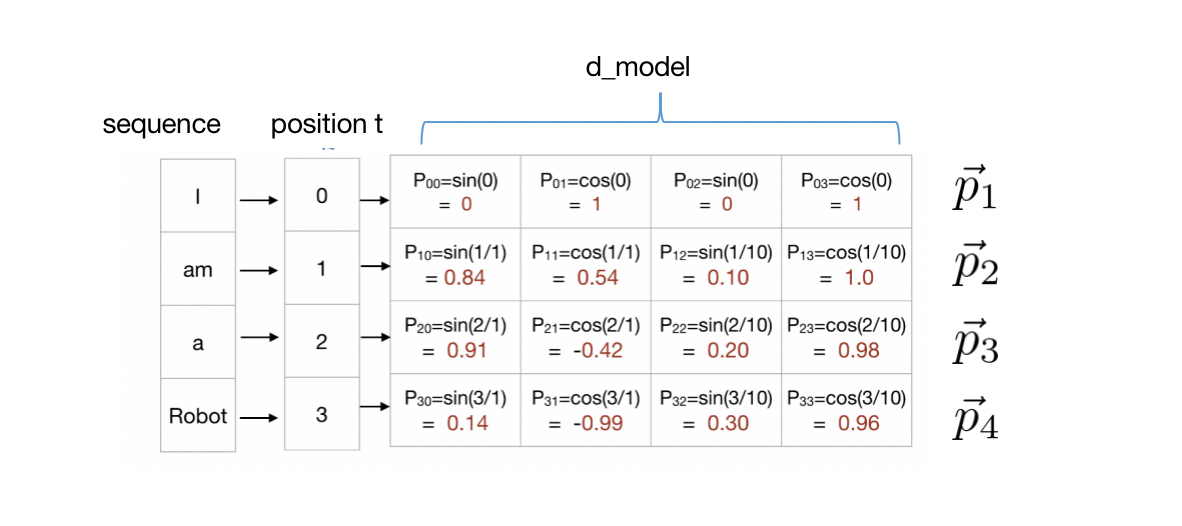

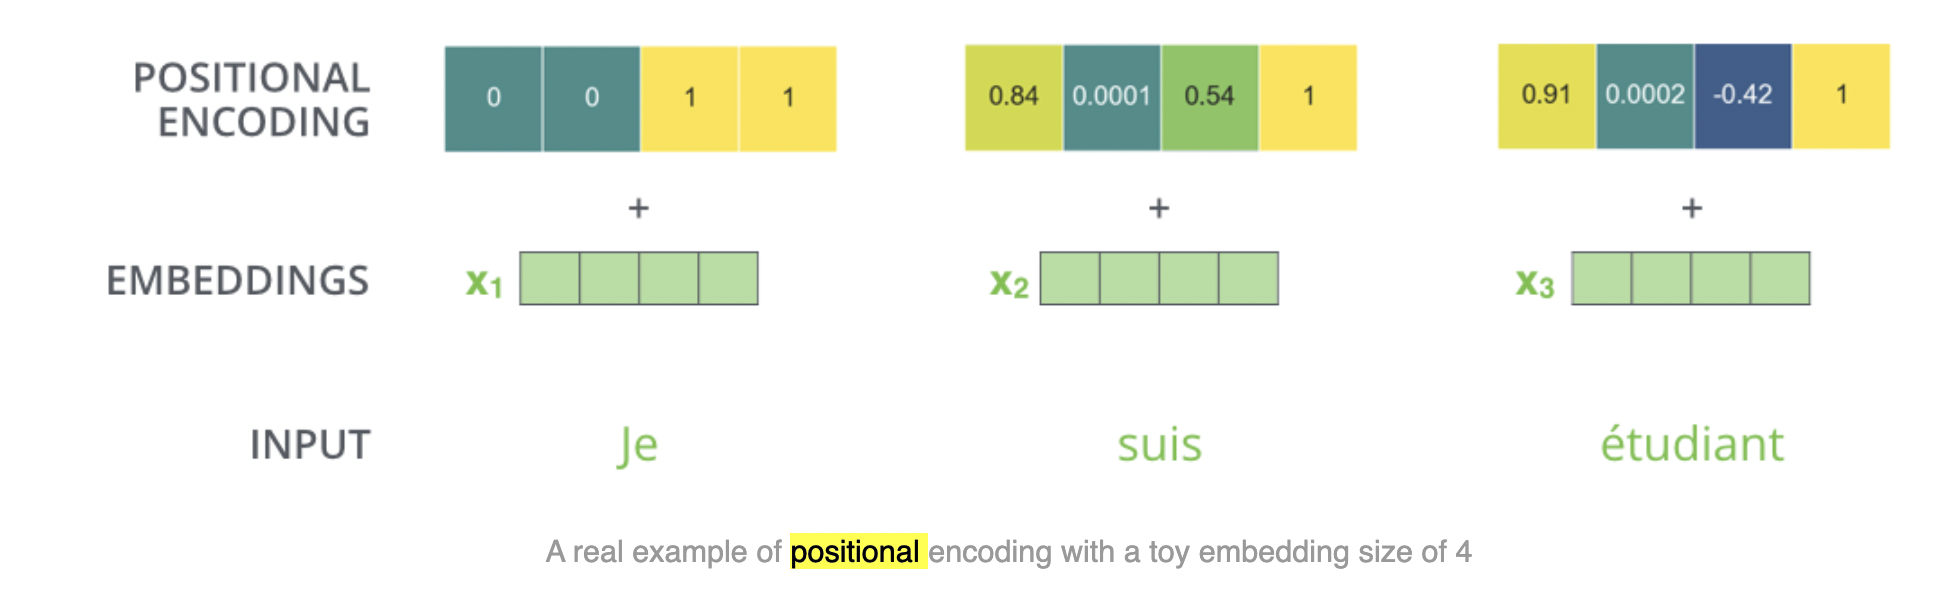

(1, 10, 64)


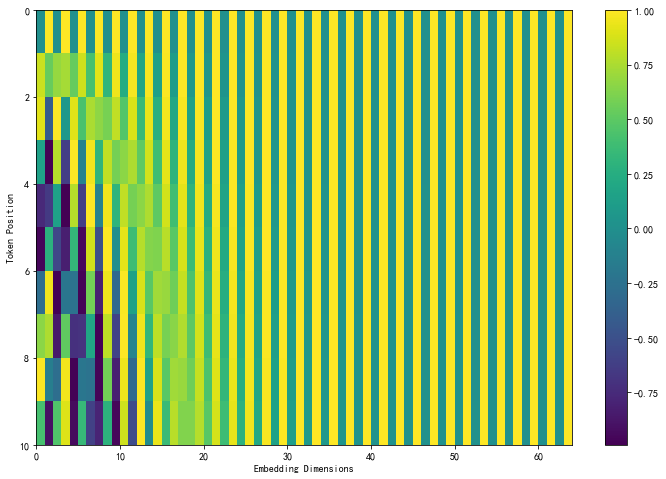

In [1]:

import numpy as np
import matplotlib.pyplot as plt

# Code from https://www.tensorflow.org/tutorials/text/transformer
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return pos_encoding


tokens = 10

dimensions = 64

pos_encoding = positional_encoding(tokens, dimensions)
print (pos_encoding.shape)

plt.figure(figsize=(12,8))
plt.pcolormesh(pos_encoding[0], cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.xlim((0, dimensions))
plt.ylim((tokens,0))
plt.ylabel('Token Position')
plt.colorbar()
plt.show()

## Training Algorithm

- Uses standard backpropagation with gradient descent or adaptive optimizers like Adam.

- Cross-entropy loss with label smoothing for improved generalization.

- Learning rate scheduling with warm-up and cool-down steps.